<h1> Predicting controller command for ailerons using airplane status and comparing which algorithm gives most accurate results</h1>

Ailerons are control surfaces on the wings of an aircraft that enable it to roll or bank. They work by changing the angle of the aileron on one wing relative to the other. When the pilot moves the control stick or yoke, one aileron goes up while the other goes down, creating differential lift and causing the aircraft to roll. This rolling motion is essential for turning and maintaining control in flight. Ailerons play a critical role in the overall stability and maneuverability of an aircraft.<br><br>
This project aims to design a controller to manage the ailerons of an aircraft based on supervised learning.

![Aileron](https://imgs.search.brave.com/BGtTr7fZLYENyb5Ya_FXsUPnioTtYztTTF-VIStJvNU/rs:fit:860:0:0/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvY29tbW9ucy9k/L2RkL0RpZmZlcmVu/dGlhbF9haWxlcm9u/cy5wbmc)




The following dataset contains 13750 instances, where each instance is a set of 40 features describing the airplane's status.

GOAL- use these features to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import scipy
import time
import matplotlib.pyplot as plt
import math


df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

In [ ]:
#Printing the dataframe.
df.head()

,inputs ClimbRate,Sgz,P,Q,CurPitch,CurRoll,AbsRoll,DiffClb,DiffRollRate,DiffDiffClb,...,DiffSeTime8,DiffSeTime9,DiffSeTime10,DiffSeTime11,DiffSeTime12,DiffSeTime13,DiffSeTime14,Alpha,Se,Goal
0,-17,-6,-0.03,0.14,0.59,-0.5,-11,-9,0.015,-0.2,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0008
1,-791,15,-0.28,-0.34,1.11,0.9,-10,27,-0.002,4.7,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.4,0.013,-0.0009
2,-46,48,-0.42,0.07,0.57,0.6,-5,-8,-0.008,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0005
3,496,-5,-0.21,-0.04,0.03,-0.5,-7,6,-0.002,-0.1,...,0.0,0.0,0.0,0.001,0.0,0.001,0.0,0.5,0.017,-0.0005
4,-124,16,-0.02,0.05,0.61,-0.2,-9,-3,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0006


In [ ]:
df.shape

(13750, 41)

In [ ]:
#Splitting data
X=df.drop(['Goal'], axis=1)
y=df.Goal
X_train , X_test1, y_train,  y_test1 = train_test_split(X,y,test_size=0.3,random_state=1)
X_val,X_test,y_val, y_test=train_test_split(X_test1,y_test1,test_size=0.5,random_state=1)

#Standardizing data
sc=StandardScaler()
Std_data_train=sc.fit_transform(X_train)
Std_Xtrain= pd.DataFrame(Std_data_train, index=X_train.index, columns=X_train.columns)
Std_data_val=sc.transform(X_val)
Std_Xval= pd.DataFrame(Std_data_val, index=X_val.index, columns=X_val.columns)
Std_data_test=sc.transform(X_test)
Std_Xtest= pd.DataFrame(Std_data_test, index=X_test.index, columns=X_test.columns)

#Adding column of ones
Xtrain = np.c_[np.ones(Std_data_train.shape[0]),Std_data_train]
Xval = np.c_[np.ones(Std_data_val.shape[0]),Std_data_val]
Xtest = np.c_[np.ones(Std_data_test.shape[0]),Std_data_test]

## Linear Regression Using Direct Solution

In [ ]:
# Direct solution
lamd=2
W = np.dot(scipy.linalg.inv(np.dot(Xtrain.T, Xtrain) + (lamd)*np.identity(np.shape(Xtrain)[1])), np.dot(Xtrain.T, y_train))

# prediction
ypred_val = np.dot(Xval, W)
ypred_train=np.dot(Xtrain,W)

#RMSE error
rmse_train=np.sqrt(mean_squared_error(ypred_train, y_train))
rmse_val=np.sqrt(mean_squared_error(ypred_val, y_val))

#Print RMSE
print("The RMSE on training data = ", rmse_train)
print("The RMSE on validation data = ", rmse_val)

The RMSE on training data =  0.0001750296504228297
The RMSE on validation data =  0.0001733647359075345


## Full Batch Gradient Descent

In [ ]:
ct=rmse_val*1.001
alpha=0.01
w=np.random.uniform(low=0, high=0.001, size=41)


rmse_train_array=[]
rmse_gdval_array=[]
start_time = time.time() ## Records current time

for epoch in range (0,1000):
  y= np.dot(Xtrain,w.T)
  rmse_train_array.append(np.sqrt(mean_squared_error(y, y_train)))
  gradient = (1/len(y) * np.dot(Xtrain.T, y-y_train))
  w = w - alpha * gradient ### weight update
  ypredval=np.dot(Xval,w.T)
  rmse_gdval=np.sqrt(mean_squared_error(ypredval, y_val))
  rmse_gdval_array.append(rmse_gdval)
  #print("epoch",epoch)
  #print("rmse-ct",rmse_gdval-ct)
  if rmse_gdval<=ct:
    break
print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))


--- Total Training Time: 1.7295382022857666 (s) ---


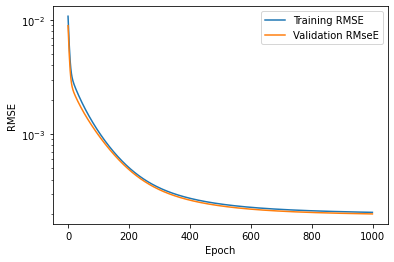

In [ ]:
plt.semilogy(rmse_train_array,label="Training RMSE")
plt.semilogy(rmse_gdval_array, label="Validation RMseE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()

plt.show()


The model fit is ideal in this case and does not overfit, since the RMSE for validation is close to training RMSE and does not diverge. This kind of fit is best for any application and an ideal case.

Such a behaviour was expected since we have performed regularized linear regression.

## Mini-batch and Stochastic Gradient Descent

In [ ]:

def mini_batch_sgd(xtrain,ytrain,xval,yval,batchsize,lr,ct=rmse_val*1.001):
  w=np.random.uniform(low=0, high=0.001, size=41)
  train_rmse=[]
  val_rmse=[]
  ep_time=[]
  starttime=time.time()
  for i in range(80):
    mini_batches = []
    train_data = np.hstack((xtrain,np.expand_dims(y_train, axis=1)))
    np.random.permutation(train_data)
    n = train_data.shape[0] // batchsize
    j = 0

    for j in range(n + 1):
        batch = train_data[j * batchsize:(j + 1)*batchsize, :]
        X = batch[:, :-1]
        Y = batch[:, -1].reshape((-1, 1))
        mini_batches.append((X, Y))
    if train_data.shape[0] % batchsize != 0:
        batch = train_data[i * batchsize:train_data.shape[0]]
        X = batch[:, :-1]
        Y = batch[:, -1].reshape((-1, 1))
        mini_batches.append((X, Y))
    for m in mini_batches:
      xt,ytt=m
      yt=ytt.flatten()
      y_tr=np.dot(xt,w.T)
      y_va=np.dot(xval,w.T)
      if len(y_tr)==0:
        break
      g=(1/len(y_tr) * np.dot(xt.T, y_tr-yt))
      w = w - lr * g
      if np.sqrt(mean_squared_error(y_va, yval)) < ct:

        break
    train_rmse.append(np.sqrt(mean_squared_error(np.dot(xtrain,w.T), ytrain)))
    val_rmse.append(np.sqrt(mean_squared_error(np.dot(xval,w.T), yval)))
    ep_time.append(time.time()-starttime)

  return w, train_rmse, val_rmse, ep_time

In [ ]:
batchsizes=[1024,512,256,64,32]
weights=[]
train_rmse=[]
val_rmse=[]
train_times=[]
ep_time=[]

for b in batchsizes:
  wei,trmse,vrmse,ti=mini_batch_sgd(Xtrain,y_train,Xval,y_val,b,0.01)
  weights.append(wei)
  train_rmse.append(trmse)
  val_rmse.append(vrmse)
  ep_time.append(ti)
  train_times.append(ti[-1])


## Plotting training and validation RMSE vs. epoch for all the converging batch sizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE.

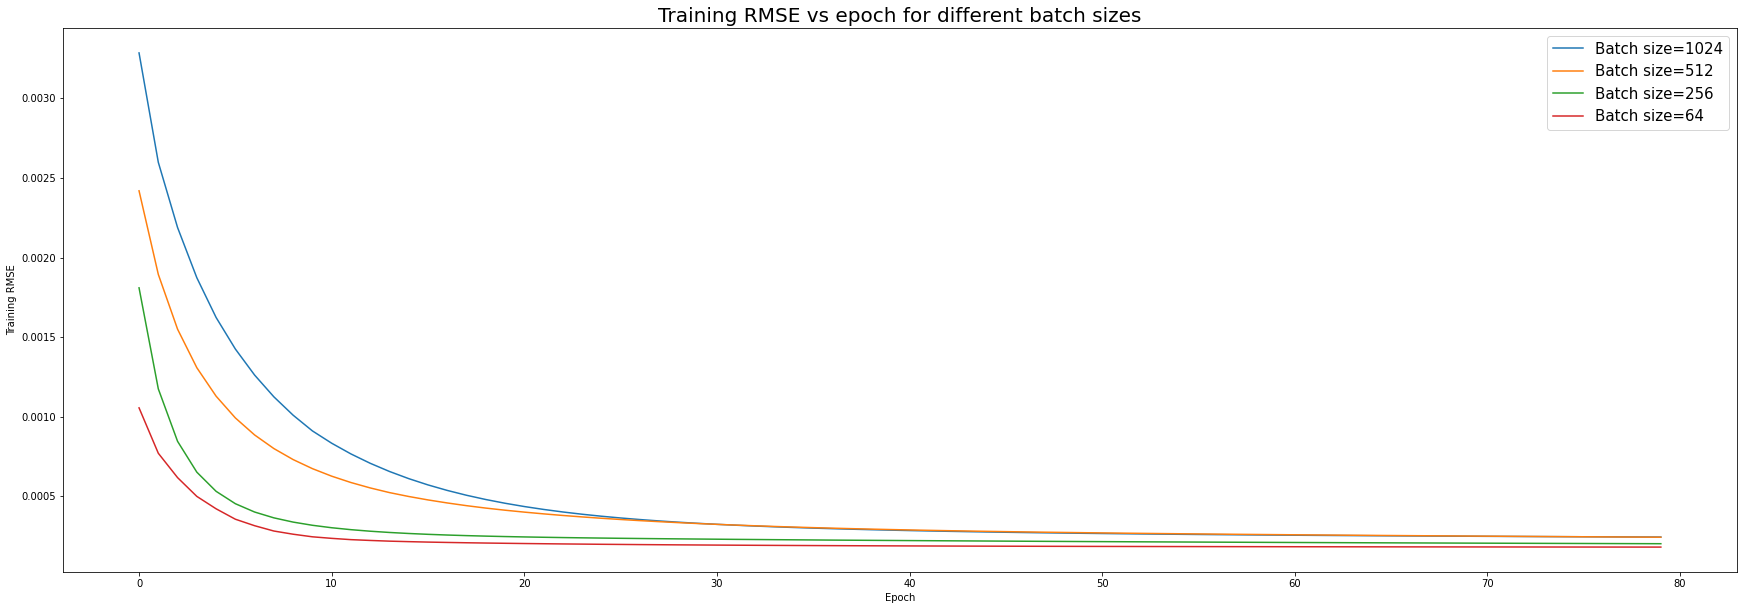

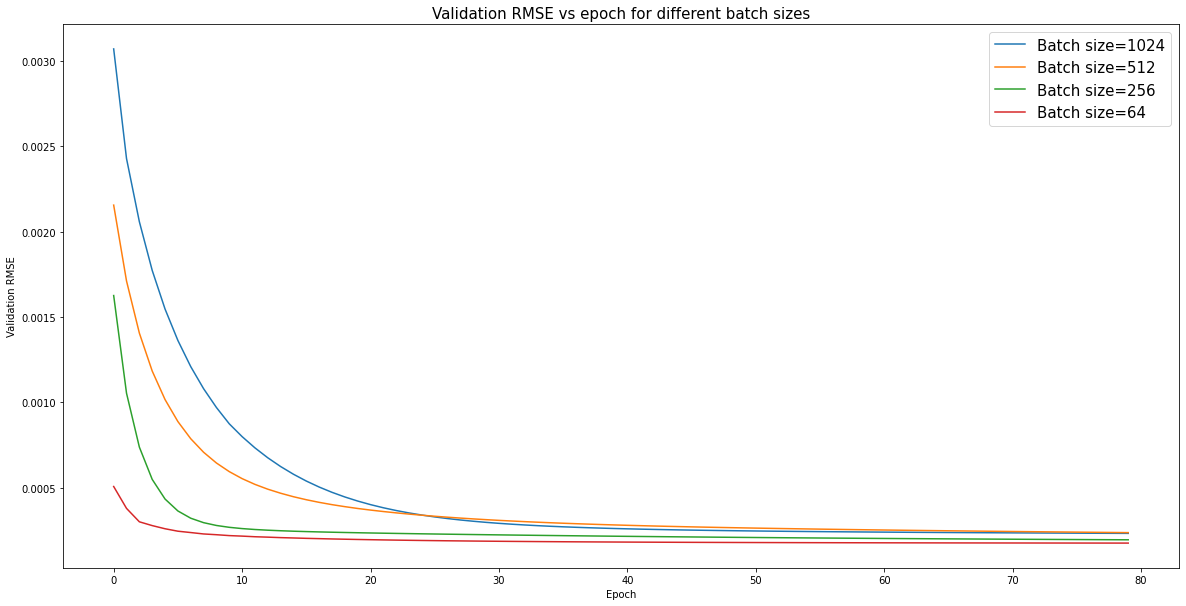

In [ ]:

plt.figure(num=1,figsize=(30,10))
labels=['Batch size=1024','Batch size=512','Batch size=256','Batch size=64','Batch size=32']
for i in range(len(batchsizes)-1):

  plt.plot(train_rmse[i],label=labels[i])
  plt.xlabel("Epoch")
  plt.ylabel("Training RMSE")
  plt.legend(fontsize = 15)
plt.title('Training RMSE vs epoch for different batch sizes',fontsize = 20)
plt.show()

plt.figure(num=1,figsize=(20,10))
for i in range(len(batchsizes)-1):

  plt.plot(val_rmse[i],label=labels[i])
  plt.xlabel("Epoch")
  plt.ylabel("Validation RMSE")
  plt.legend(fontsize = 15)
plt.title('Validation RMSE vs epoch for different batch sizes',fontsize = 15)
plt.show()


In [ ]:
batchsizes1=[64,32,16,8]
weightsn=[]
train_rmsen=[]
val_rmsen=[]
train_timesn=[]
ep_timen=[]

for b in batchsizes1:
  wei,trmse,vrmse,ti=mini_batch_sgd(Xtrain,y_train,Xval,y_val,b,0.01)
  weightsn.append(wei)
  train_rmsen.append(trmse)
  val_rmsen.append(vrmse)
  ep_timen.append(ti)
  train_timesn.append(ti[-1])


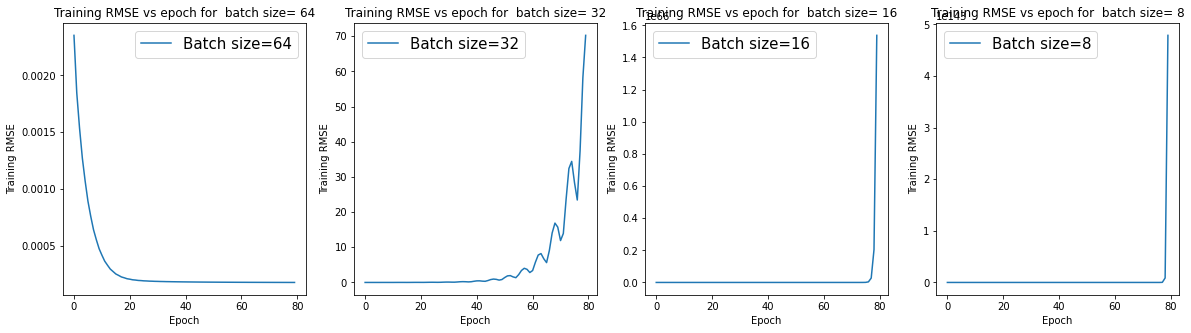

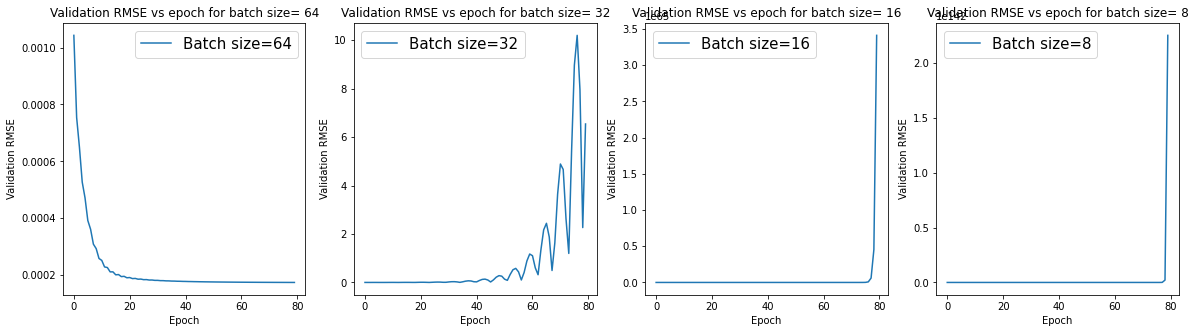

In [ ]:
#plots to explore convergence of smaller batch sizes
labelsn=['Batch size=64','Batch size=32','Batch size=16','Batch size=8']
plt.figure(num=1,figsize=(20,5))

for i in range(len(batchsizes1)):
  plt.subplot(1,4,i+1)
  plt.title('Training RMSE vs epoch for  batch size= ' + str(batchsizes1[i]))
  plt.plot(train_rmsen[i],label=labelsn[i])
  plt.xlabel("Epoch")
  plt.ylabel("Training RMSE")
  plt.legend(fontsize = 15)

plt.show()

plt.figure(num=1,figsize=(20,5))

for i in range(len(batchsizes1)):
  plt.subplot(1,4,i+1)

  plt.plot(val_rmsen[i],label=labelsn[i])
  plt.xlabel("Epoch")
  plt.ylabel("Validation RMSE")
  plt.legend(fontsize = 15)
  plt.title('Validation RMSE vs epoch for batch size= '+str(batchsizes1[i]))

plt.show()

## Plotting training and validation RMSE vs. time for all the converging batch sizes in a figure. The X-axis is Time, and the Y-axis is RMSE.

Batch sizes that converge are 1024,512,256,64 whereas batch sizes 32 and less have spikes, diverge and their training RMSE keeps on increasing.

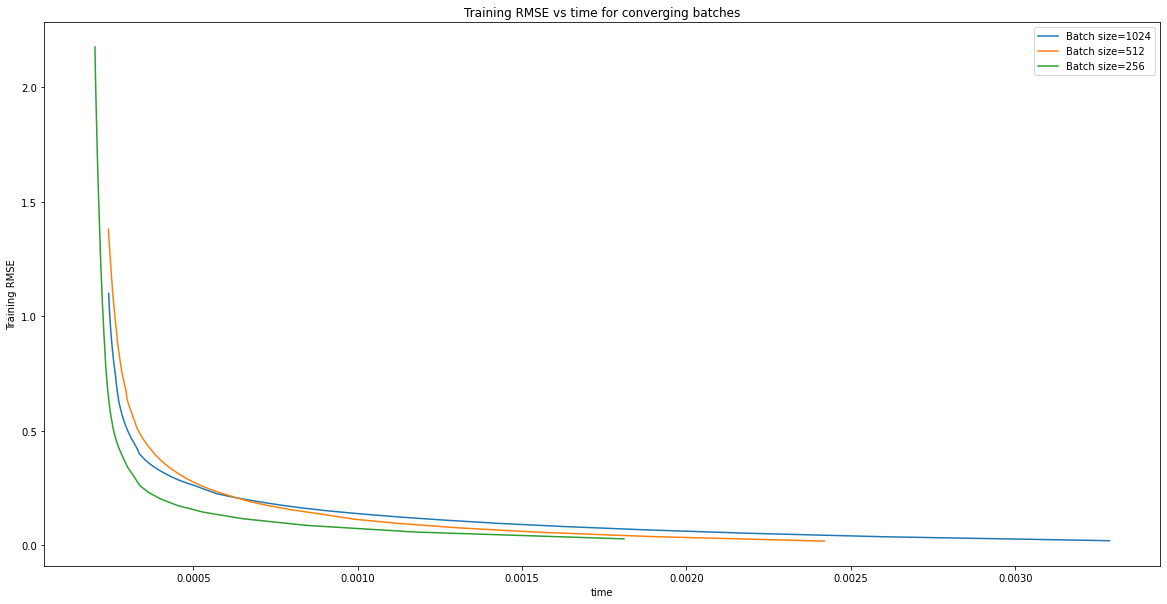

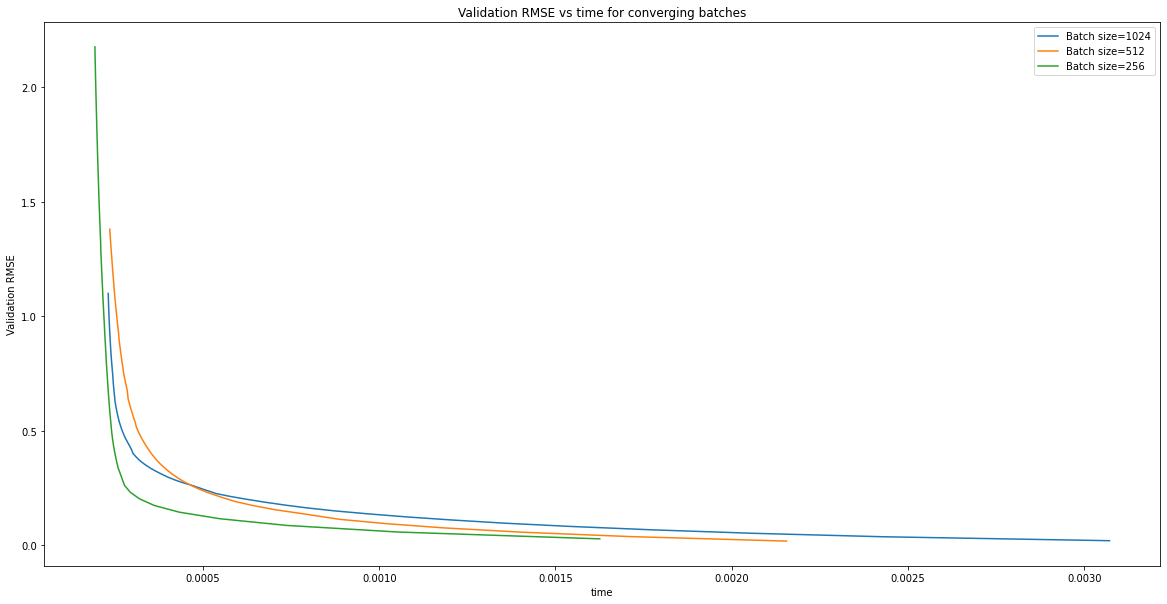

In [ ]:
plt.figure(figsize=(20,10))
for i in range(3):

  plt.plot(train_rmse[i][:80],ep_time[i],label=labels[i])
  plt.xlabel("time")
  plt.ylabel("Training RMSE")
  plt.legend()
plt.title('Training RMSE vs time for converging batches')
plt.show()

plt.figure(figsize=(20,10))
for i in range(3):

  plt.plot(val_rmse[i][:80],ep_time[i],label=labels[i])
  plt.xlabel("time")
  plt.ylabel("Validation RMSE")
  plt.legend()
plt.title('Validation RMSE vs time for converging batches')
plt.show()

## Plotting Total training time (y-axis) vs. Batch size (x-axis).

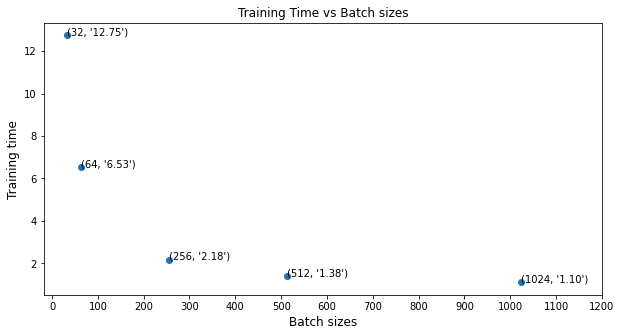

In [ ]:

plt.figure(figsize=(10,5))
plt.scatter(batchsizes,train_times)
plt.xticks(np.arange(0,1300,step=100),color='black')
plt.xlabel('Batch sizes',fontsize=12)
plt.ylabel('Training time',fontsize=12)
plt.title('Training Time vs Batch sizes')
for i in range(5):
  plt.annotate((batchsizes[i],'{0:.2f}'.format(train_times[i])),(batchsizes[i],train_times[i]))


* For mini batch gradient descent the hyperparameters that affect the performance are the batch size and learning rate. It is found that for a fixed learning rate = 0.01, RMSE converges for batch sizes greater than 32.

* For smaller batchsizes we need to reduce the learning rate because we get a diverging RMSE for higher learning rate due to which the value of gradient takes huge jumps on the gradient curve and does not approach a global minimum.

* On observing the training time vs batch size graph, we find that batch size of 1024 takes the least time to train at learning rate=0.01

1. Finding learning rate for non-converging batch sizes.

In [ ]:

bsizes=[32,16,8]
train_rmse1=[]
val_rmse1=[]
ep_time1=[]
lrate=np.arange(0.001,0.01,step=0.001)

for j,b in enumerate(bsizes):
  batch_trmse=[]
  batch_vrmse=[]
  batch_ep_time=[]

  for lr in lrate:
    wei,trmse,vrmse,ti=mini_batch_sgd(Xtrain,y_train,Xval,y_val,b,float(lr))
    batch_trmse.append(trmse)
    batch_vrmse.append(vrmse)
    batch_ep_time.append(ti)

  train_rmse1.append(batch_trmse)
  val_rmse1.append(batch_vrmse)
  ep_time1.append(batch_ep_time)

In [ ]:
model_trainrmse=[]
model_valrmse=[]
for i in range(3):
  mtrmse=[]
  mvrmse=[]
  for j in range(9):
    mtrmse.append(train_rmse1[i][j][-1])
    mvrmse.append(val_rmse1[i][j][-1])
  model_trainrmse.append(mtrmse)
  model_valrmse.append(mvrmse)


In [ ]:
best_lr=[]
min_vrmse=[]
min_trmse=[]
model_train_time=[]
for i in range(3):
    min_vrmse.append(np.amin(model_valrmse[i]))
    ind= np.argmin(model_valrmse[i])
    best_lr.append(lrate[ind])
    min_trmse.append(model_trainrmse[i][ind])
    model_train_time.append(ep_time1[i][ind][-1])

#Results

In [ ]:
results=pd.DataFrame({"Batch size":bsizes,
                      "Learning Rate":best_lr,
                      "Train RMSE":min_trmse,
                      "Validation RMSE":min_vrmse,
                      "Training time":model_train_time})
results

,Batch size,Learning Rate,Train RMSE,Validation RMSE,Training time
0,32,0.009,0.000539,0.000173,8.302690
1,16,0.002,0.000179,0.000174,20.168863
2,8,0.001,0.000181,0.000177,45.369117



The best batch size with least training time is 1024 with training time=1.13seconds

In [ ]:
#Sweeping through different learning rates
btrmse=[]
bvrmse=[]
btime=[]
learnr=np.arange(0.001,0.011,step=0.001)
for lr in learnr:
    best_wei,best_trmse,best_vrmse,best_ti=mini_batch_sgd(Xtrain,y_train,Xval,y_val,1024,float(lr))
    btrmse.append(best_trmse)
    bvrmse.append(best_vrmse)
    btime.append(best_ti)

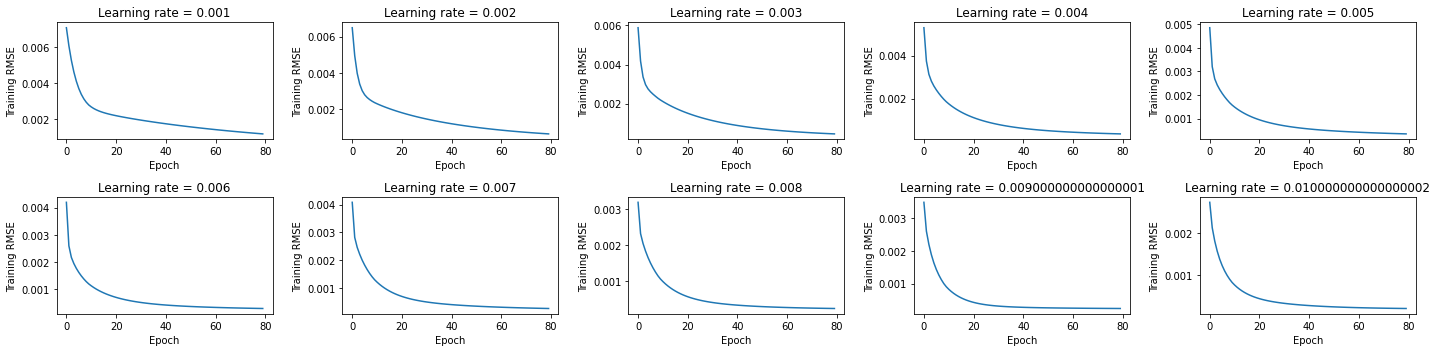

In [ ]:
#Training RMSE vs epoch plots
plt.figure(figsize=(20,5))
for j in range(10):

    plt.subplot(2,5,j+1)

    plt.title('Learning rate = ' + str(learnr[j]))
    plt.plot(btrmse[j])
    plt.xlabel("Epoch")
    plt.ylabel("Training RMSE")

    plt.tight_layout()



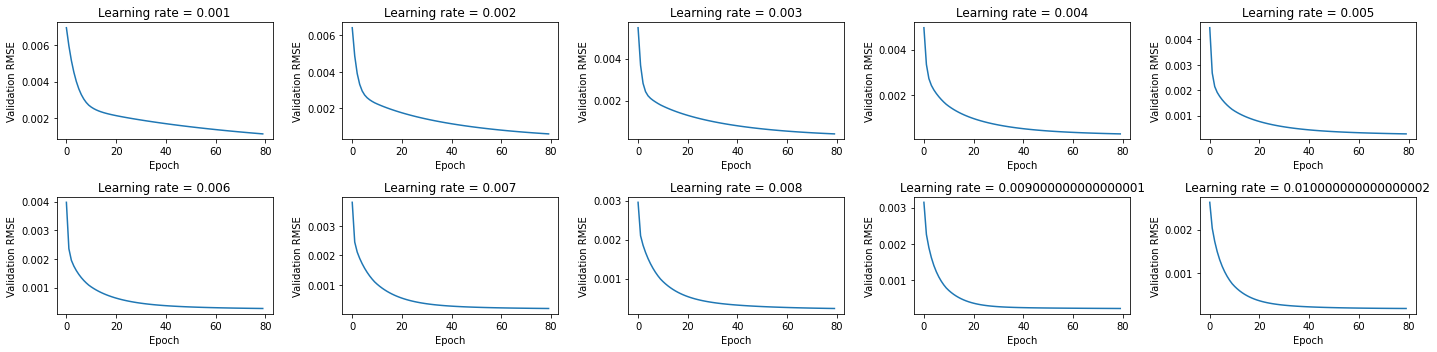

In [ ]:
#Validation RMSE vs epoch plots
plt.figure(figsize=(20,5))
for j in range(10):

    plt.subplot(2,5,j+1)

    plt.title('Learning rate = ' + str(learnr[j]))
    plt.plot(bvrmse[j])
    plt.xlabel("Epoch")
    plt.ylabel("Validation RMSE")

    plt.tight_layout()

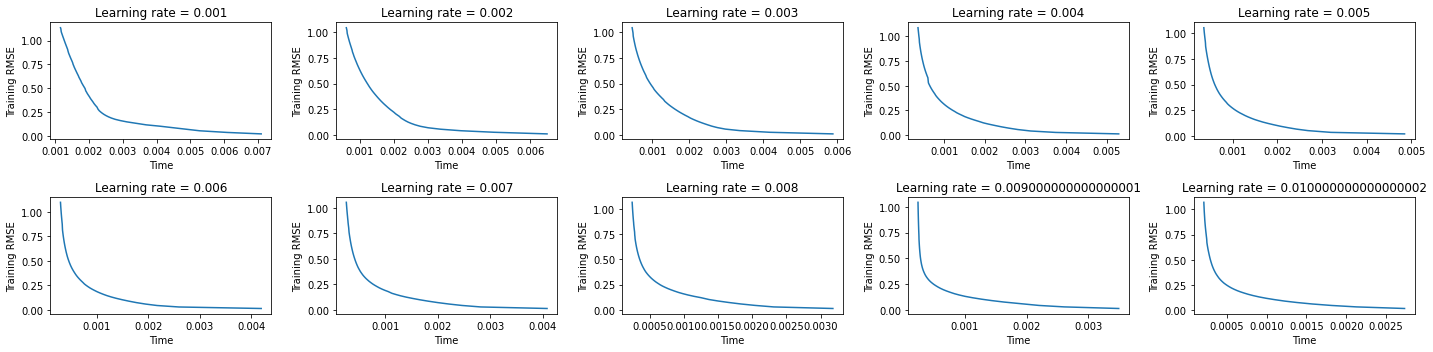

In [ ]:
#Training RMSE vs time plots
plt.figure(figsize=(20,5))
for j in range(10):

    plt.subplot(2,5,j+1)

    plt.title('Learning rate = ' + str(learnr[j]))
    plt.plot(btrmse[j],btime[j])
    plt.xlabel("Time")
    plt.ylabel("Training RMSE")

    plt.tight_layout()

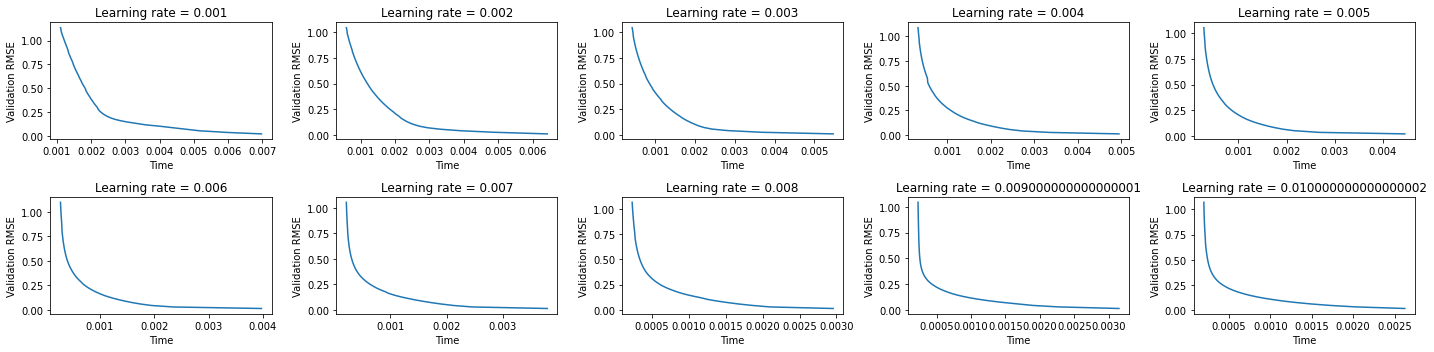

In [ ]:
#Validation RMSE vs time plots
plt.figure(figsize=(20,5))
for j in range(10):

    plt.subplot(2,5,j+1)

    plt.title('Learning rate = ' + str(learnr[j]))
    plt.plot(bvrmse[j],btime[j])
    plt.xlabel("Time")
    plt.ylabel("Validation RMSE")

    plt.tight_layout()

In [ ]:
batchtrain_rmse=[]
batchval_rmse=[]
for j in range(10):
    batchtrain_rmse.append(btrmse[j][-1])
    batchval_rmse.append(bvrmse[j][-1])


minbatch_vrmse=np.amin(batchval_rmse)
inde=np.argmin(batchval_rmse)
bestbatch_lr=learnr[inde]
minbatch_trmse=batchtrain_rmse[inde]
best_batch_train_time=btime[inde][-1]



* The RMSE which diverged for learning rate = 0.01 converges for a learning rate that is less than 0.01. For example, as illiustrated in the table above batch size=8 converges for lewarning rate of 0.001 which is ten times less than the initial learning rate for which it diverged.
* Minimum Validation RMSE is achieved with lesser batch sizes is equal to 0.000173 for a batch size of 32 and learning rate = 0.009. It also has the least training time compared to other lower batch sizes.

## Finalizing a model




The selected model parameters are:

* Learning rate = 0.01
* Batch size = 1024
* Training time= 1.07s
* Validation RMSE = 0.0002



In [ ]:

y_test_pred=np.dot(Xtest,best_wei.T)
test_rmse=np.sqrt(mean_squared_error(y_test,y_test_pred))
print("RMSE on Test data = ", test_rmse)

RMSE on Test data =  0.00025830126284691855


In [ ]:
best_batch_results=pd.DataFrame({
    "Batch size": 1024,
    "Learning rate":[bestbatch_lr],
    "Training RMSE":[minbatch_trmse],
    "Validation RMSE":[minbatch_vrmse],
    "Test RMSE":test_rmse,
    "Training time":[best_batch_train_time]
})
print("Resuts of the best model on test data")
best_batch_results.transpose()

Resuts of the best model on test data


,0
Batch size,1024.000000
Learning rate,0.010000
Training RMSE,0.000213
Validation RMSE,0.000200
Test RMSE,0.000258
Training time,1.070137




The model works as expected with a little higher test RMSE (within allowed threshold). Considering the achieved test RMSE, it will be safe to be say that the task of managing the ailerons will be carried out smoothly with an error of just 0.000258.